# Multivariate linear regression

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
data_df = pd.read_csv("../data/polar_dataset.csv")

In [3]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
0,0.0,347.349127,-0.937748,80.620806,-73.996722,4.0,0.000000,126.09445,9.49647,1.479466e+09,4.0,5.0,-2751.871739,-32568.992278,-445.591802
1,0.0,347.454256,-1.023284,81.014459,-73.952718,4.0,125.000000,126.18450,9.40926,1.479466e+09,0.0,0.0,-2634.693985,-32565.342209,-434.138091
2,0.0,347.559538,-1.108477,81.405345,-73.908071,4.0,127.083336,126.27455,9.32193,1.479466e+09,0.0,0.0,-2517.481310,-32561.795217,-422.610325
3,0.0,347.664456,-1.192763,81.790901,-73.862459,4.0,130.208340,126.36455,9.23460,1.479466e+09,0.0,0.0,-2400.351546,-32558.011667,-411.009522
4,0.0,347.769287,-1.277690,82.176902,-73.816395,4.0,131.250000,126.45445,9.14730,1.479466e+09,0.0,0.0,-2283.352731,-32554.038396,-399.342470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5262970,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.000000,43.83530,-15.99588,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002
5262971,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.000000,43.93020,-16.08015,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772
5262972,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.000000,44.02525,-16.16439,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294
5262973,0.0,274.481898,-5.197639,261.290657,84.662301,4.0,0.000000,44.12035,-16.24857,1.491273e+09,0.0,0.0,20949.138349,-18581.787518,-3575.998276


In [4]:
corr = data_df.corr()

In [5]:
corr

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
saa,1.000000,0.008131,0.019461,-0.146167,-0.128785,-0.142659,-0.184700,0.002887,0.047496,-0.076861,0.058351,0.041201,-0.005760,-0.057570,0.042619
raz,0.008131,1.000000,0.083527,-0.114804,0.190301,-0.006030,-0.164876,-0.017019,0.026996,-0.029898,-0.012645,0.006483,-0.026997,-0.019561,-0.001825
decz,0.019461,0.083527,1.000000,-0.096701,0.083359,-0.337315,-0.005575,-0.006812,0.952733,-0.016209,-0.025139,-0.006533,-0.906323,-0.425191,-0.006280
rax,-0.146167,-0.114804,-0.096701,1.000000,0.195639,0.030754,0.172211,0.001744,-0.138125,-0.229382,0.054844,0.050510,0.132297,0.067000,0.010851
decx,-0.128785,0.190301,0.083359,0.195639,1.000000,0.059696,0.036561,-0.006216,-0.161624,-0.010165,0.043913,0.054292,0.150984,0.095078,0.000073
obox_mode,-0.142659,-0.006030,-0.337315,0.030754,0.059696,1.000000,-0.020455,-0.108804,-0.354177,0.004112,-0.381835,-0.414227,0.189356,0.468773,-0.271070
sum_fe_temp,-0.184700,-0.164876,-0.005575,0.172211,0.036561,-0.020455,1.000000,0.001774,-0.024944,0.095260,0.127505,0.112883,0.026669,0.005235,0.011424
glon,0.002887,-0.017019,-0.006812,0.001744,-0.006216,-0.108804,0.001774,1.000000,-0.002236,-0.000338,0.088133,0.079806,0.156317,-0.198840,-0.296584
glat,0.047496,0.026996,0.952733,-0.138125,-0.161624,-0.354177,-0.024944,-0.002236,1.000000,-0.000559,-0.048113,-0.032696,-0.948355,-0.463218,-0.004082
tunix,-0.076861,-0.029898,-0.016209,-0.229382,-0.010165,0.004112,0.095260,-0.000338,-0.000559,1.000000,-0.058350,-0.073236,0.000730,-0.002749,0.004364


In [6]:
corr["sum_fe_rate"]

saa              0.041201
raz              0.006483
decz            -0.006533
rax              0.050510
decx             0.054292
obox_mode       -0.414227
sum_fe_temp      0.112883
glon             0.079806
glat            -0.032696
tunix           -0.073236
sum_fe_cosmic    0.926909
sum_fe_rate      1.000000
B_r              0.087670
B_theta          0.278132
B_phi           -0.039451
Name: sum_fe_rate, dtype: float64

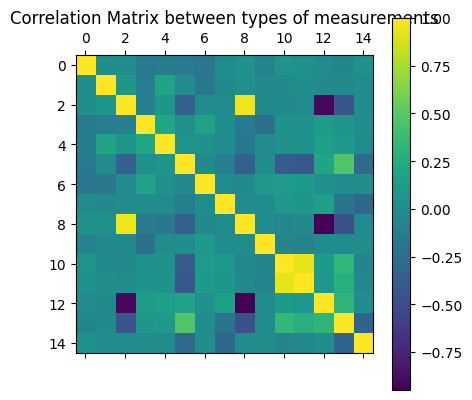

In [7]:
plt.matshow(corr)
plt.colorbar()

plt.title('Correlation Matrix between types of measurements')
plt.show()

We can observe, a high Pearson linear correlation between `sum_fe_rate` and `sum_fe_cosmic` as Nicolas Produit has previously shown me during his explanations using ROOT CERN tool.

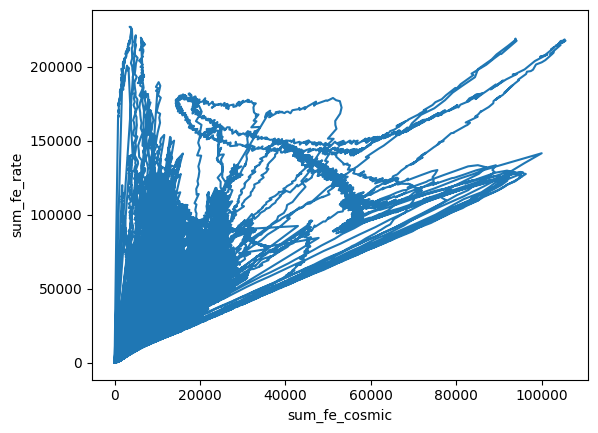

In [8]:
# We don't scatter plot so that we can also see the temporal connection
plt.plot(data_df["sum_fe_cosmic"], data_df["sum_fe_rate"])
plt.xlabel("sum_fe_cosmic")
plt.ylabel("sum_fe_rate")
plt.show()

However, it's not sufficient to pass a line through it !! However we'll still do it just to observe the predicted light curve

## Linear regression only using `sum_fe_cosmic`

We'll use as target variable `sum_fe_rate`, not its reconstructed version from FFT. Moreover, a linear regression has a gaussian noise assumption as well as i.i.d examples.. which is very restrictive

Let's split the dataset

In [9]:
# TODO: split the dataset.. no test set here
result = stats.linregress(data_df["sum_fe_cosmic"], data_df["sum_fe_rate"])

print(f"Slope a: {result.slope}, Intercept b: {result.intercept},\nR^2: {result.rvalue**2}, p-value: {result.pvalue}")
print("\n"+f"std_a: {result.stderr}, std_b: {result.intercept_stderr}")

Slope a: 2.0768931132978645, Intercept b: 1908.0315300679267,
R^2: 0.8591602865766419, p-value: 0.0

std_a: 0.00036654225261941256, std_b: 2.6935940341576425


In [10]:
# TODO: learn about confidence intervals

This means that there's around $ 85.9 \%$ less variation around the regression line than the average `sum_fe_rate`, which is great and our p-value (which is less than 0.05) tells us that it's statistically significant to reject the null hypothesis stating that the slope is 0. Therefore, our R-squared is statistically significant meaning that it might be useful using the linear relation between `sum_fe_rate` and `sum_fe_cosmic`.

In [15]:
y = data_df['sum_fe_rate']
y_hat = data_df['sum_fe_cosmic']*result.slope + result.intercept

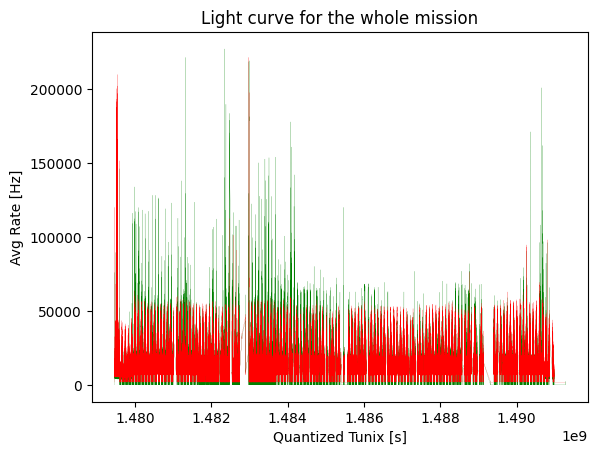

In [16]:
plt.plot(data_df['tunix'], y, 'g', linewidth=0.1)
plt.plot(data_df['tunix'], y_hat, 'r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

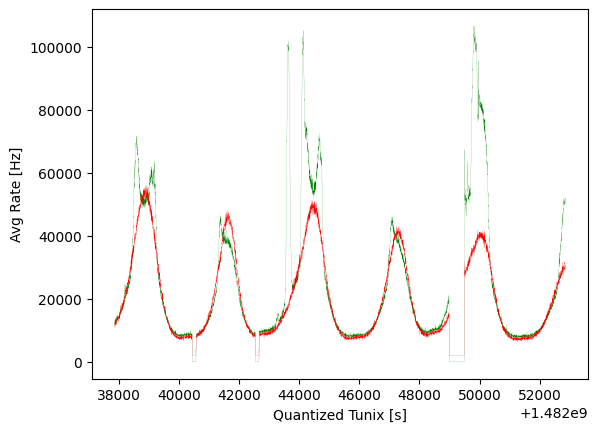

In [19]:
# Mask used to select a portion of the mission
t = data_df['tunix']
mask = (t>(5000+1482032854)) & (t<(20000+1482032854))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.plot(t[mask], y_hat[mask], 'r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()